# Introduction

Welcome to the **notebook** version of Tetouan city power consumption analysis, created by Zakaria El-Aoufi. 

In this notebook, we will explore the electricity consumption behavior of Tetouan city residents. The data represents three distinct zones, each reflecting power consumption measured in kilowatt-hours (kWh). Through this notebook, I aim to provide a comprehensive analysis of power consumption patterns.

This notebook comprises two essential parts:

1. **Exploratory Data Analysis (EDA):** A detailed exploration of the dataset to uncover patterns, trends, and anomalies.
2. **Machine Learning Regression Model:** A forecasting model to predict future consumption based on specific variables outlined below.

# Dataset Variables

Here are the key variables included in the dataset:

- **DateTime:** Timestamps recorded at 10-minute intervals.
- **Temperature:** Weather temperature in Tetouan city.
- **Humidity:** Weather humidity in Tetouan city.
- **Wind Speed:** Wind speed recorded in Tetouan city.
- **General Diffuse Flows:** General diffuse radiation flows.
- **Diffuse Flows:** Specific diffuse radiation flows.
- **Zone 1 Power Consumption (Target):** Power consumption in Zone 1 (kWh).
- **Zone 2 Power Consumption (Target):** Power consumption in Zone 2 (kWh).
- **Zone 3 Power Consumption (Target):** Power consumption in Zone 3 (kWh).

# Goals

The primary objectives of this analysis are:

- To understand the consumption behavior across different zones.
- To identify factors influencing power consumption.
- To build a machine learning regression model for forecasting future power consumption.

Let's dive into the data analysis and modeling process.

# Setup my Environment

In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Load data

In [531]:
power_consumption = pd.read_csv('./data/power_consumption.csv')
power_consumption.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,Zone 2,Zone 3
0,01-01-2017 00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,01-01-2017 00:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,01-01-2017 00:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,01-01-2017 00:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,01-01-2017 00:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [532]:
power_consumption.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,Zone 2,Zone 3
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


In [533]:
power_consumption.isnull().sum()

DateTime                 0
Temperature              0
Humidity                 0
Wind Speed               0
general diffuse flows    0
diffuse flows            0
Zone 1                   0
Zone 2                   0
Zone 3                   0
dtype: int64

# Data Manipulation

## Fix columns Names and Type 

In [534]:
# fix data columns names by removing leading spase 
power_consumption.columns = power_consumption.columns.str.strip()
# fix datatime column to datetime type
power_consumption['DateTime'] = pd.to_datetime(power_consumption['DateTime'], format='mixed')

In [535]:
# Transform power consumption from kWh to MWh for better visualization
power_consumption[['Zone 1', 'Zone 2', 'Zone 3']] = power_consumption[['Zone 1', 'Zone 2', 'Zone 3']] / 1000

## Duplicate Detection

In [536]:
dlen1 = power_consumption.shape[0]
power_consumption = power_consumption.drop_duplicates(keep='first')
dlen2 = power_consumption.shape[0]
print(f'{dlen1 - dlen2} rows removed')

0 rows removed


## Generate Hourly, Daily, Weekly and Monthly data

In [537]:
day_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

month_names = {
        1: 'January',
        2: 'February',
        3: 'March',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: 'August',
        9: 'September',
        10: 'October',
        11: 'November',
        12: 'December'
}

agg_dict = {
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Wind Speed': 'mean',
    'general diffuse flows': 'mean',
    'diffuse flows': 'mean',
    'Zone 1': 'sum',
    'Zone 2': 'sum',
    'Zone 3': 'sum'
}

### Hourly Consumption

In [538]:
def resample_timeseries(pow_con: pd.DataFrame, frec: str) -> pd.DataFrame:
    data = pow_con.copy()
    data = data.set_index('DateTime')
    resampled_df = data.resample(frec).agg(agg_dict)
    resampled_df.reset_index(inplace=True)
    return resampled_df

In [539]:
hourly_consumption = resample_timeseries(power_consumption, 'h')

hourly_consumption['hour'] = hourly_consumption['DateTime'].dt.hour
hourly_consumption['day'] = hourly_consumption['DateTime'].dt.day
hourly_consumption['month'] = hourly_consumption['DateTime'].dt.month
hourly_consumption['year'] = hourly_consumption['DateTime'].dt.year

In [540]:
hourly_consumption.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,Zone 2,Zone 3,hour,day,month,year
0,2017-01-01 00:00:00,6.196833,75.066667,0.081833,0.063500,0.098833,175.187848,108.160486,115.512289,0,1,1,2017
1,2017-01-01 01:00:00,5.548833,77.583333,0.082000,0.056833,0.112500,147.943291,96.470517,102.257349,1,1,1,2017
2,2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,132.498228,85.984195,94.056867,2,1,1,2017
3,2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,124.866835,79.316717,89.303133,3,1,1,2017
4,2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,122.855696,77.529483,85.902651,4,1,1,2017


### Daily Consumption

In [541]:
daily_consumption = resample_timeseries(power_consumption, 'D')

daily_consumption['day'] = daily_consumption['DateTime'].dt.day
daily_consumption['month'] = daily_consumption['DateTime'].dt.month
daily_consumption['year'] = daily_consumption['DateTime'].dt.year
daily_consumption['Weekday'] = daily_consumption['DateTime'].dt.weekday
daily_consumption["IsWeekend"] = daily_consumption['Weekday'] >= 5

# Add a new column for month names
daily_consumption['Day Name'] = daily_consumption['Weekday'].map(day_names)

In [542]:
daily_consumption.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,Zone 2,Zone 3,day,month,year,Weekday,IsWeekend,Day Name
0,2017-01-01,9.675299,68.519306,0.315146,121.390771,25.993924,4098.993418,2554.241945,2573.106506,1,1,2017,6,True,Sunday
1,2017-01-02,12.476875,71.456319,0.076563,120.404486,27.227410,4157.207089,2816.312462,2566.189880,2,1,2017,0,False,Monday
2,2017-01-03,12.100000,74.981667,0.076715,120.686014,28.574660,4400.992405,2888.246809,2537.395663,3,1,2017,1,False,Tuesday
3,2017-01-04,10.509479,75.459792,0.082417,122.959319,28.827222,4419.335696,2894.699088,2545.012048,4,1,2017,2,False,Wednesday
4,2017-01-05,10.866444,71.040486,0.083896,118.749861,29.741437,4435.619241,2884.887538,2543.641446,5,1,2017,3,False,Thursday


### Monthly Consumption

In [543]:
monthly_data = resample_timeseries(power_consumption, 'ME')

monthly_data['month'] = monthly_data['DateTime'].dt.month
monthly_data['year'] = monthly_data['DateTime'].dt.year

# Add a new column for month names
monthly_data['Month Name'] = monthly_data['month'].map(month_names)

In [544]:
monthly_data.head()

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,Zone 2,Zone 3,month,year,Month Name
0,2017-01-31,12.743092,68.294122,0.707927,103.343396,68.687413,138529.051139,86576.801216,79218.569639,1,2017,January
1,2017-02-28,12.644443,66.551322,1.096494,125.768940,91.627936,124934.558644,75752.381763,69894.728683,2,2017,February
2,2017-03-31,14.579907,71.100029,1.006189,181.090957,93.983753,139076.658383,82396.232927,75654.470323,3,2017,March
3,2017-04-30,16.444463,75.242521,0.224269,159.399087,84.302805,134653.398665,76178.734827,80322.484364,4,2017,April
4,2017-05-31,20.293564,68.712440,2.298271,273.666324,123.048394,144615.784918,89178.613003,78660.594656,5,2017,May


# Data Visualization

## Hourly Power Consumption

In [545]:
def plot_hourly_consumption(data, month, day):
    # Filter data for the specified day
    day_data = data[(data['month'] == month) & (data['day'] == day)]
    
    # Create the line plot
    plt.figure(figsize=(14, 8))
    sns.lineplot(
        x='hour', 
        y='Zone 1', 
        data=day_data, 
        label='Zone 1', 
        color='blue', 
        marker='o'
    )
    sns.lineplot(
        x='hour', 
        y='Zone 2', 
        data=day_data, 
        label='Zone 2', 
        color='green', 
        marker='o'
    )
    sns.lineplot(
        x='hour', 
        y='Zone 3', 
        data=day_data, 
        label='Zone 3', 
        color='red', 
        marker='o'
    )
    
    # Add title and labels
    plt.title(
        f'Hourly Power Consumption in MWh for 2017-{month}-{day}', 
        fontsize=16, 
        fontweight='bold', 
        pad=20
    )
    plt.xlabel('Hour of the Day', fontsize=14, fontweight='bold')
    plt.ylabel('Megawatt-Hours (MWh)', fontsize=14, fontweight='bold')
    
    # Set x-axis ticks to show all hours
    plt.xticks(range(0, 24))
    
    # Add grid lines for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend(title='Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # Show the plot
    plt.show()

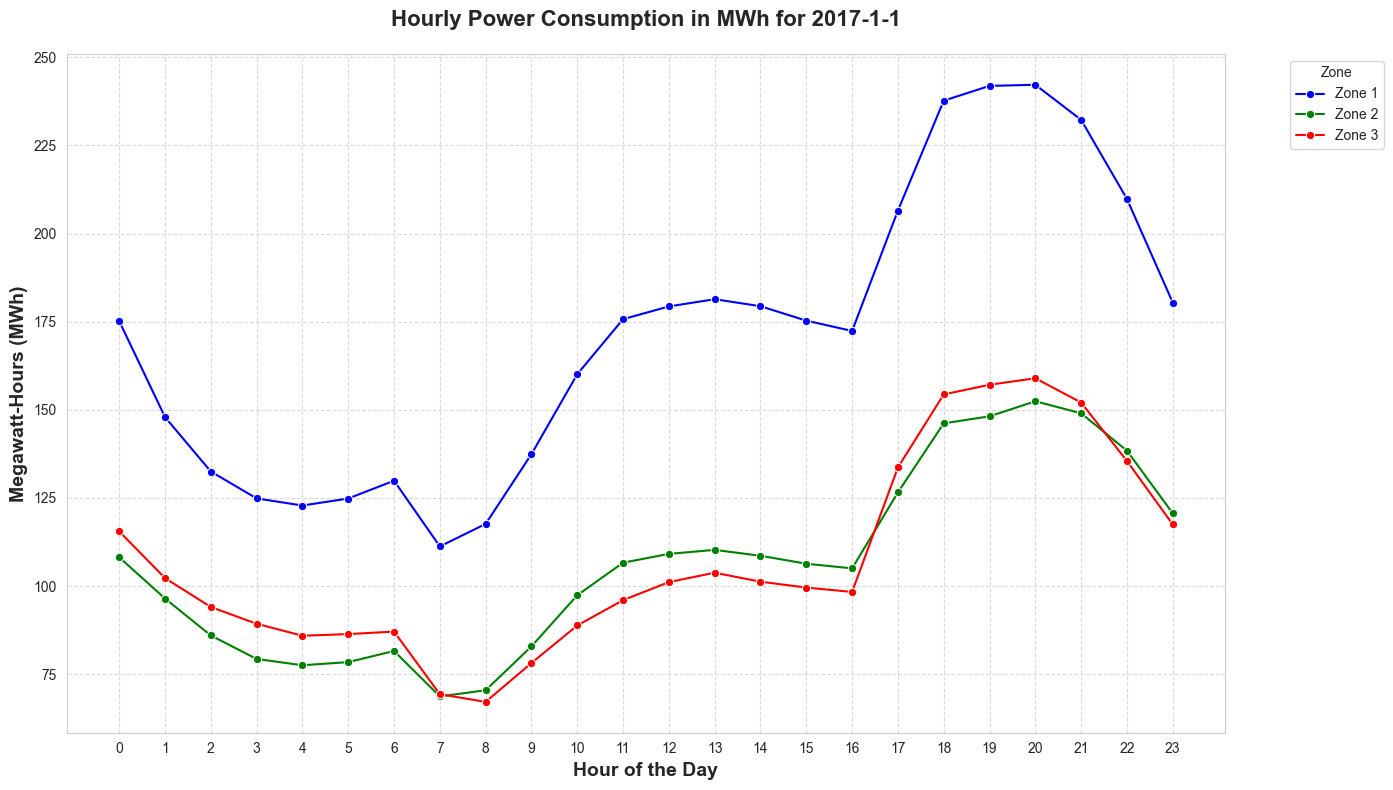

In [546]:
plot_hourly_consumption(hourly_consumption, month=1, day=1)

## Hypothesis Testing for the Behaviour Consumption of Different Zone 

## Plot Electrical Consumption for WeekDays 

In [547]:
data_by_weekdays = daily_consumption.groupby(['month','Weekday','Day Name',])[['Zone 1', 'Zone 2', 'Zone 3']].sum()
data_by_weekdays = data_by_weekdays.reset_index()

In [548]:
data_by_weekdays.head()

,month,Weekday,Day Name,Zone 1,Zone 2,Zone 3
0,1,0,Monday,22179.803544,13970.359879,12729.796627
1,1,1,Tuesday,22670.582278,14036.235866,12766.802892
2,1,2,Wednesday,18275.295190,11527.692401,10254.777831
3,1,3,Thursday,18390.774684,11641.477204,10292.067470
4,1,4,Friday,18182.624810,11589.764134,10063.922892


In [549]:
def plot_zones_by_month(data, month):
    # Filter data for the specified month
    month_data = data[data['month'] == month]
    
    # Melt the DataFrame to long format for easier plotting
    melted_data = month_data.melt(
        id_vars=['Weekday', 'Day Name'], 
        value_vars=['Zone 1', 'Zone 2', 'Zone 3'], 
        var_name='Zone', 
        value_name='Consumption (MWh)'
    )
    
    # Create the bar plot
    plt.figure(figsize=(14, 8))
    sns.barplot(
        x='Day Name', 
        y='Consumption (MWh)', 
        hue='Zone', 
        data=melted_data, 
        palette='Blues', 
        ci=None  # Disable confidence intervals
    )
    
    # Add title and labels
    plt.title(
        f'Power Consumption by Zone in Tetouan (2017) - {month_names[month]}', 
        fontsize=16, 
        fontweight='bold', 
        pad=20
    )
    plt.xlabel('Day of the Week', fontsize=14, fontweight='bold')
    plt.ylabel('Megawatt-Hours (MWh)', fontsize=14, fontweight='bold')
    
    # Add grid lines for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend(title='Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # Show the plot
    plt.show()

C:\Users\zakar\AppData\Local\Temp\ipykernel_17688\983530623.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


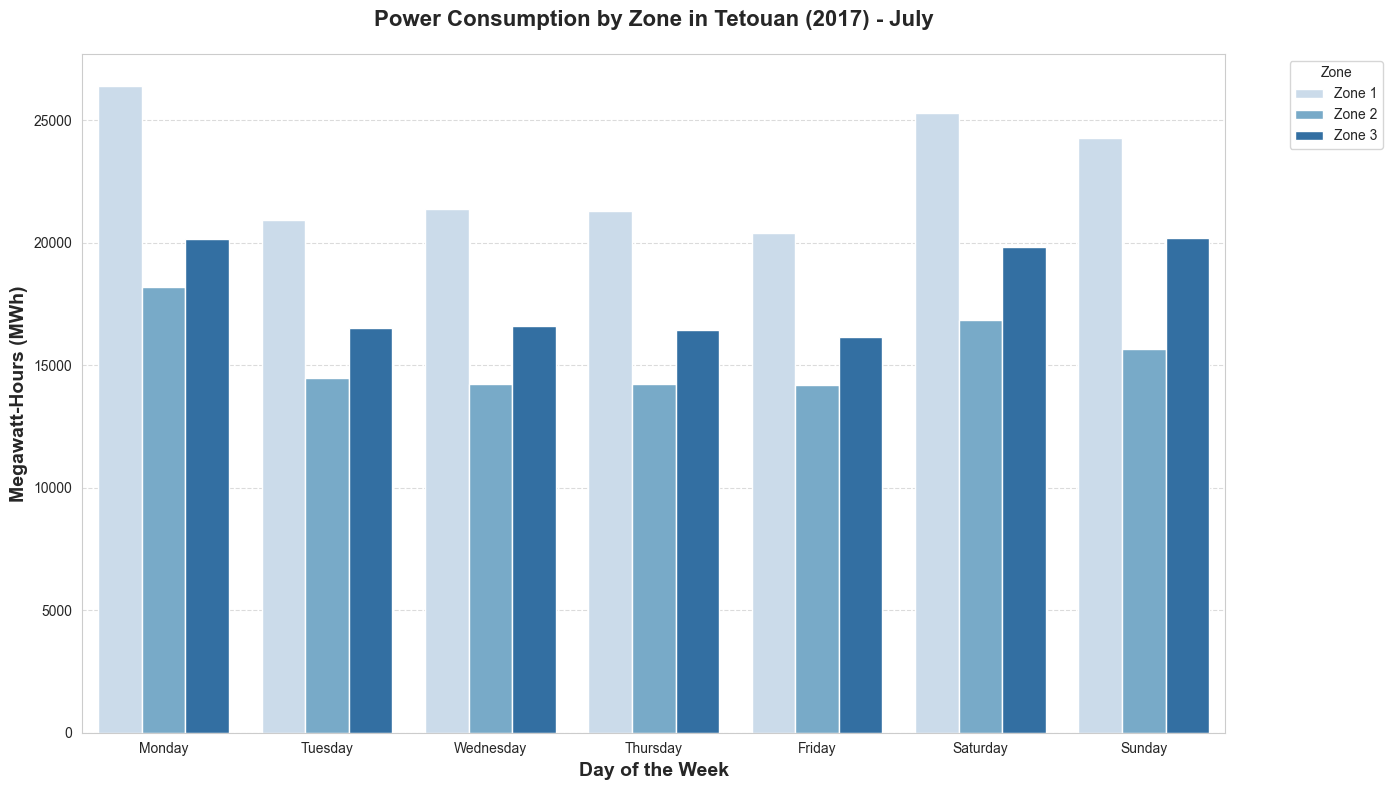

In [550]:
plot_zones_by_month(data_by_weekdays, month=7)

## Plot Electrical Consumption for WeekDays by Zone

In [551]:
def pie_viz_weekday_by_month(data,month,zone):
    month_data = data[data['month'] == month]

    # Extract Zone 1 (MWh) and Day Name for July
    zone_data = month_data[zone]
    
    # Create the pie chart
    plt.figure(figsize=(14, 8))  # Set figure size
    plt.pie(zone_data, labels=month_data['Day Name'], autopct='%1.1f%%', startangle=140)
    
    # Add a title
    plt.title(f'Distribution of {zone} Power Consumption (MWh) in {month_names[month]} by Day of the Week')
    
    # Show the plot
    plt.show()

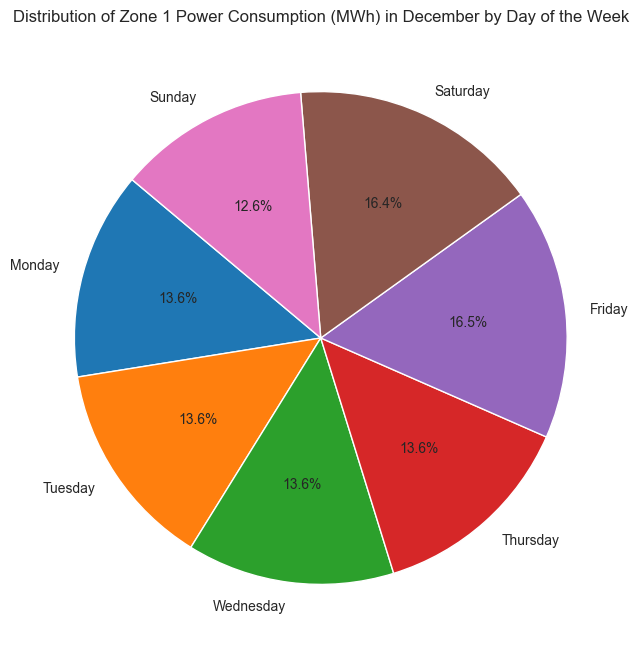

In [552]:
pie_viz_weekday_by_month(data_by_weekdays,12,'Zone 1')

## Electrical Consumption for WeekDays vs WeekEnd 

In [553]:
data_by_weekdays_weekend = daily_consumption.groupby(['month','IsWeekend',])[['Zone 1', 'Zone 2', 'Zone 3']].sum()
data_by_weekdays_weekend = data_by_weekdays_weekend.reset_index()
data_by_weekdays_weekend['IsWeekend'] = data_by_weekdays_weekend['IsWeekend'].map(lambda x: 'WeekEnd' if x == True else 'WeekDays')
data_by_weekdays_weekend['Month Name'] = data_by_weekdays_weekend['month'].map(month_names)

In [554]:
data_by_weekdays_weekend.head()

,month,IsWeekend,Zone 1,Zone 2,Zone 3,Month Name
0,1,WeekDays,99699.080506,62765.529483,56107.367711,January
1,1,WeekEnd,38829.970633,23811.271732,23111.201928,January
2,2,WeekDays,90074.739661,55396.869301,49689.534392,February
3,2,WeekEnd,34859.818983,20355.512462,20205.194291,February
4,3,WeekDays,104276.925957,62772.091464,55993.558065,March


In [555]:
def stacked_bar_by_month(data, zone):
    # Pivot the data to get WeekDays and WeekEnd as columns
    pivot_data = data.pivot(index='Month Name', columns='IsWeekend', values=zone)
    
    # Plot the stacked bar chart
    pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6), color=['lightblue', 'darkblue'])
    
    # Add labels and title
    plt.xlabel('Month')
    plt.ylabel(f'{zone}')
    plt.title(f'Stacked Bar Plot of {zone} by Month (WeekDays vs. WeekEnd)')
    plt.legend(title='IsWeekend',bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0,)  # Keep month labels horizontal
    plt.show()

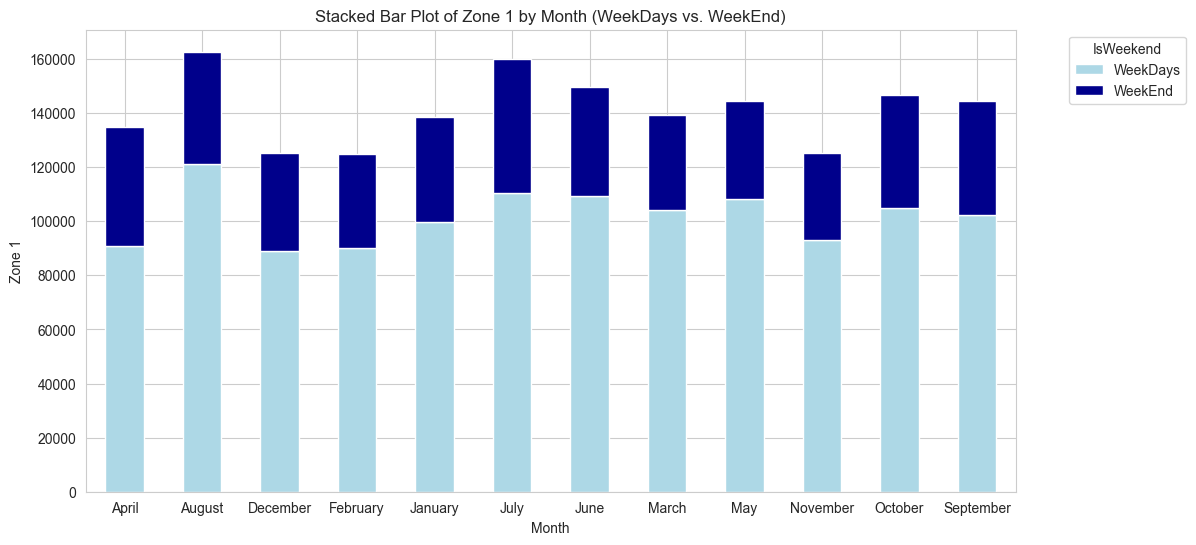

In [556]:
stacked_bar_by_month(data_by_weekdays_weekend, 'Zone 1')

In [557]:
def pie_viz_weekday_weekend_by_month(data,month,zone):
    month_data = data[data['month'] == month]

    # Extract Zone 1 (MWh) and Day Name for July
    zone_data = month_data[zone]
    
    # Create the pie chart
    plt.figure(figsize=(14, 8))  # Set figure size
    plt.pie(zone_data, labels=month_data['IsWeekend'], autopct='%1.1f%%', startangle=140)
    
    # Add a title
    plt.title(f'Distribution of {zone} Power Consumption (MWh) in {month_names[month]} by WeekEnd vs WeekDays')
    
    # Show the plot
    plt.show()

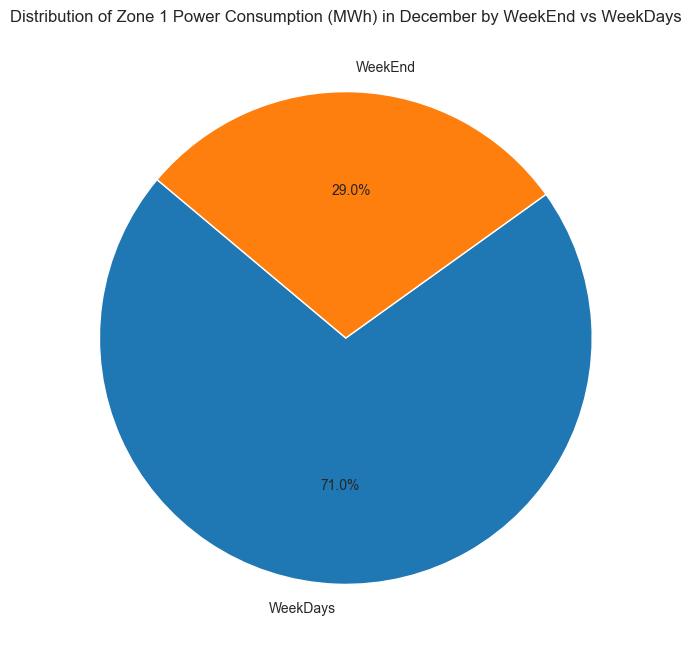

In [558]:
pie_viz_weekday_weekend_by_month(data_by_weekdays_weekend,12,'Zone 1')

## Daily Consumption 

In [559]:
def daily_consumption_by_month(data,month,zone):
    # Filter data for the specified month
    month_data = data[data['month'] == month]
    
    # Create the bar plot
    plt.figure(figsize=(14, 8))
    sns.barplot(
        x='DateTime', 
        y=zone, 
        data=month_data, 
        palette='Blues'
    )
    
    # Add title and labels
    plt.title(
        f'Daily Power Consumption in MWh for {zone} in Tetouan (2017) - {month_names[month]}', 
        fontsize=16, 
        fontweight='bold', 
        pad=20
    )
    plt.xlabel('Date', fontsize=14, fontweight='bold')
    plt.ylabel('Megawatt-Hours (MWh)', fontsize=14, fontweight='bold')
    
    # Format x-axis labels for better readability
    plt.xticks(rotation=60, ha='right')  # Rotate x-axis labels and align them to the right
    
    # Add grid lines for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # Show the plot
    plt.show()

C:\Users\zakar\AppData\Local\Temp\ipykernel_17688\632072021.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


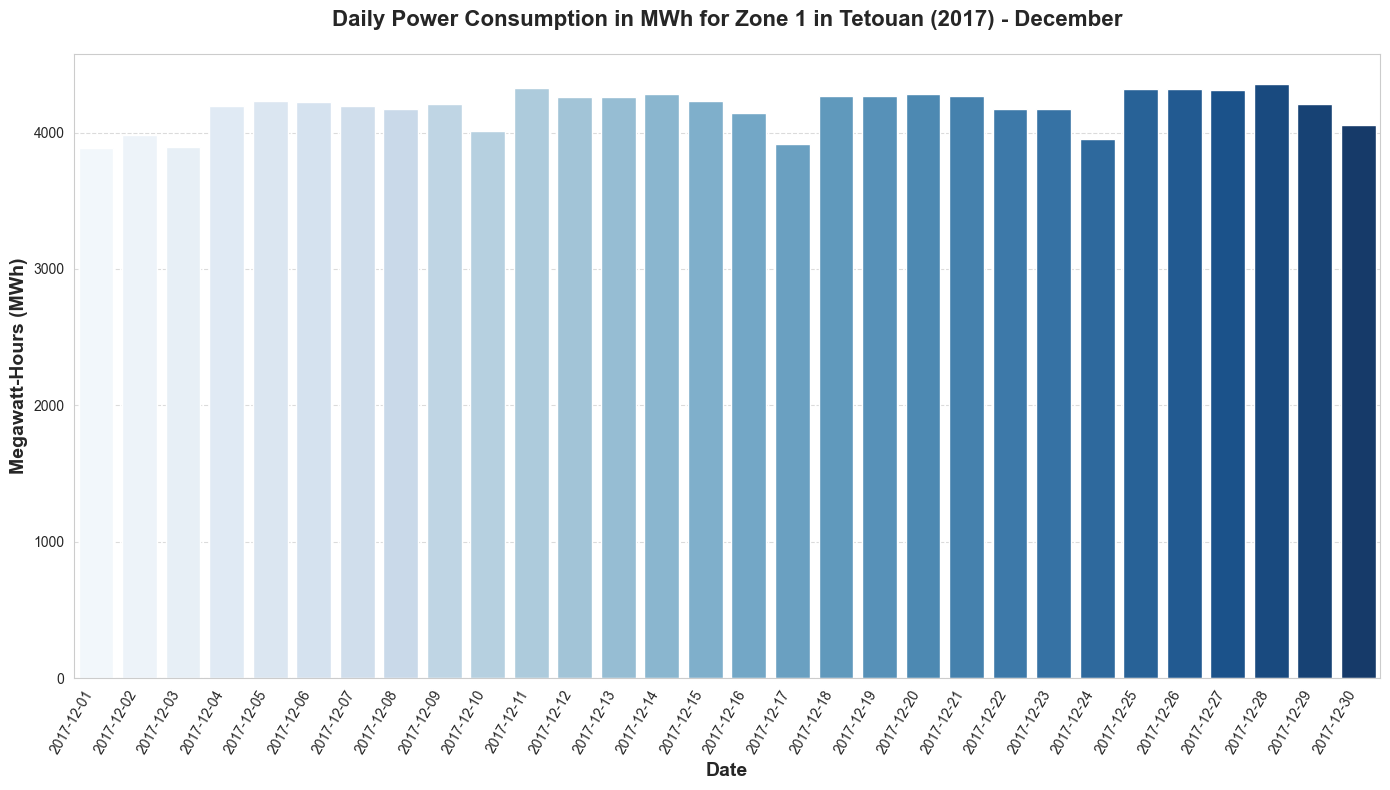

In [560]:
daily_consumption_by_month(daily_consumption,12,'Zone 1')

## Monthly Consumption by Year

In [561]:
def consumption_by_month(data,zone):
    
    # Create the bar plot
    plt.figure(figsize=(14, 8))
    sns.barplot(
        x='Month Name', 
        y=zone, 
        data=data, 
        palette='Blues'
    )
    
    # Add title and labels
    plt.title(
        f'Monthly Power Consumption in MWh for {zone} in Tetouan (2017) ', 
        fontsize=16, 
        fontweight='bold', 
        pad=20
    )
    plt.xlabel('', fontsize=14, fontweight='bold')
    plt.ylabel('Megawatt-Hours (MWh)', fontsize=14, fontweight='bold')
        
    # Add grid lines for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    
    # Show the plot
    plt.show()

C:\Users\zakar\AppData\Local\Temp\ipykernel_17688\3772263292.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


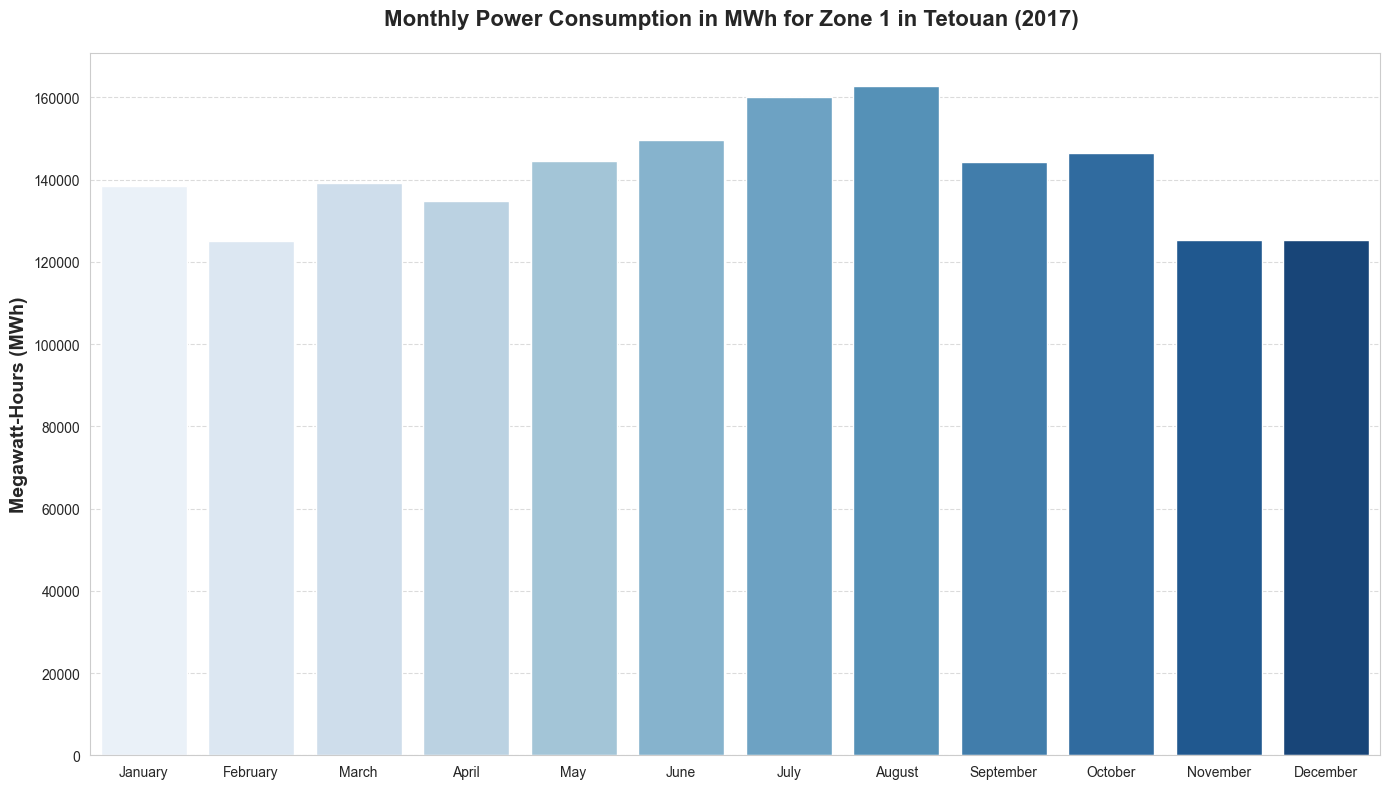

In [562]:
consumption_by_month(monthly_data,'Zone 1')

# Model Setup

## Data Standardization

In [563]:
# Select numeric columns but exclude 'day' and 'month'
numeric_columns = hourly_consumption.select_dtypes(include=['float64', 'int64', 'int32']).drop('year', axis=1)

In [564]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_columns)
scaled_power_consumption = pd.DataFrame(scaled_data, columns=numeric_columns.columns, index=hourly_consumption.index)

In [565]:
scaled_power_consumption.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1,Zone 2,Zone 3,hour,day,month
0,-2.171958,0.439885,-0.802274,-0.700266,-0.626053,-0.445213,-0.583897,0.214948,-1.661325,-1.673394,-1.601748
1,-2.283541,0.602514,-0.802203,-0.700292,-0.625939,-1.087605,-0.961123,-0.120249,-1.516862,-1.673394,-1.601748
2,-2.368693,0.689752,-0.802060,-0.700268,-0.625799,-1.451780,-1.299509,-0.327626,-1.372399,-1.673394,-1.601748
3,-2.377303,0.570203,-0.801847,-0.700280,-0.625701,-1.631719,-1.514663,-0.447840,-1.227936,-1.673394,-1.601748
4,-2.361231,0.374187,-0.802060,-0.700287,-0.625852,-1.679139,-1.572336,-0.533833,-1.083473,-1.673394,-1.601748


## Outliers Detection and Handling

### Box plots to detect outliers

In [566]:
def plot_multiple_boxplots(data):
    # Select only numeric columns
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

    # (Optional) Plot box plots for the standardized data
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=data[numeric_columns])
    plt.title('Outlier Detection (Standardized Data)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

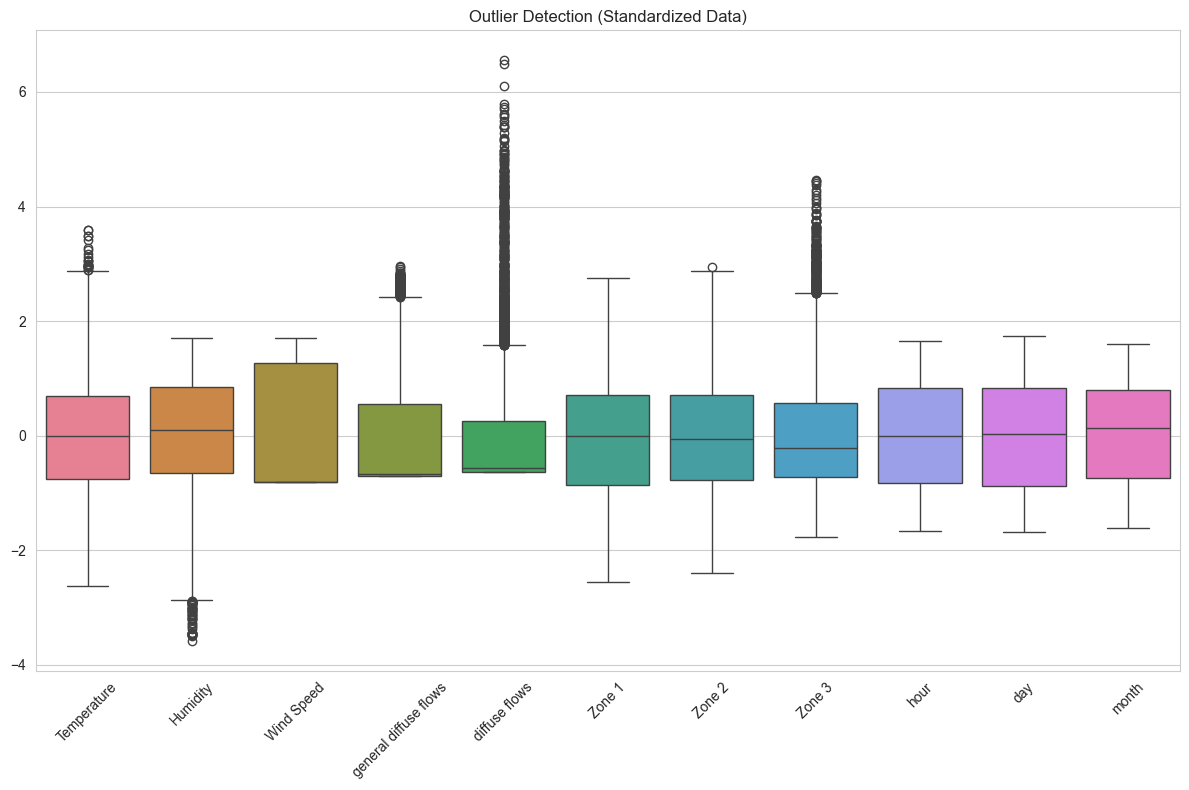

In [567]:
plot_multiple_boxplots(scaled_power_consumption)

### Diffuse Flows Assumptions

<Axes: xlabel='DateTime', ylabel='general diffuse flows'>

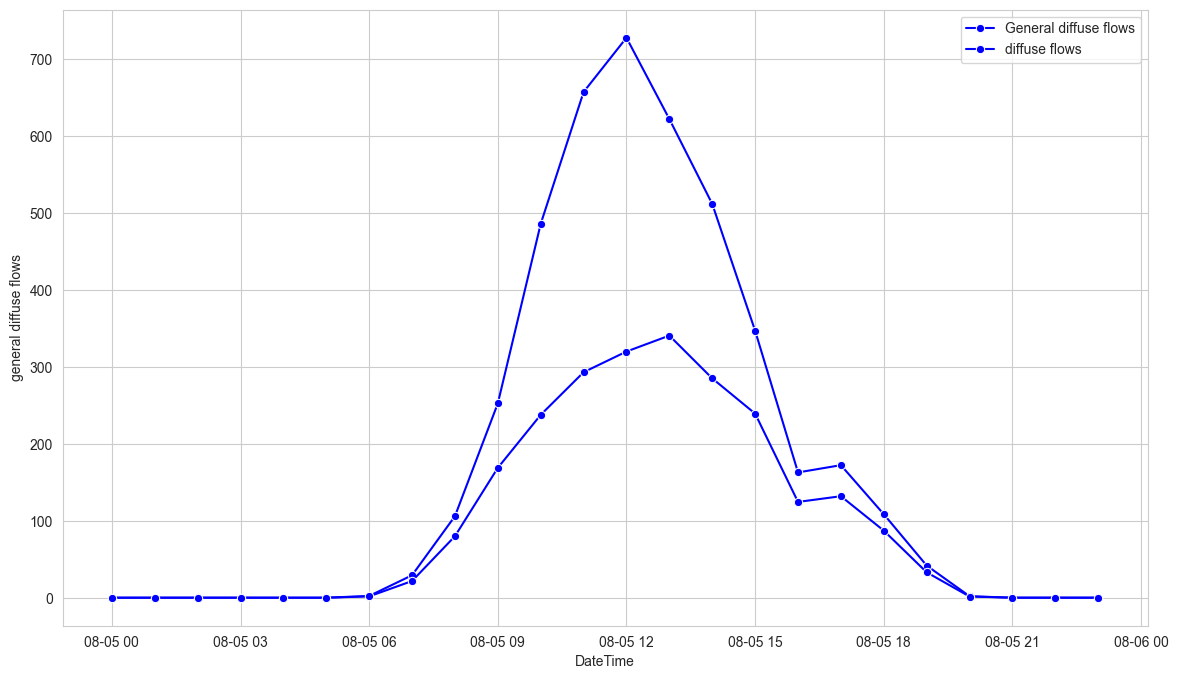

In [568]:
diffuse_data = hourly_consumption[(hourly_consumption['month'] == 8) & (hourly_consumption['day'] == 5)]
    
# Create the line plot
plt.figure(figsize=(14, 8))
sns.lineplot(
        x='DateTime', 
        y='general diffuse flows', 
        data=diffuse_data, 
        label='General diffuse flows', 
        color='blue', 
        marker='o'
)

sns.lineplot(
        x='DateTime', 
        y='diffuse flows', 
        data=diffuse_data, 
        label='diffuse flows', 
        color='blue', 
        marker='o'
)

**Conclusion:** After plotting the diffusion and general diffusion, we can conclude that the higher values are not outliers but are most likely related to the period between sunrise and sunset.

### IQR Method for Outliers Deletion

In [569]:
def remove_outliers_iqr(data):
    # Select only numeric columns
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    
    # Create a copy of the DataFrame to avoid modifying the original
    df_cleaned = data.copy()
    
    for col in numeric_columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        
        IQR = Q3 - Q1
        
        # Define the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove rows with values outside the bounds
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    
    return df_cleaned

In [570]:
power_consumption_cleaned = remove_outliers_iqr(scaled_power_consumption)

In [586]:
print(f'{scaled_power_consumption.shape[0]-power_consumption_cleaned.shape[0]} rows removed')

1239 rows removed


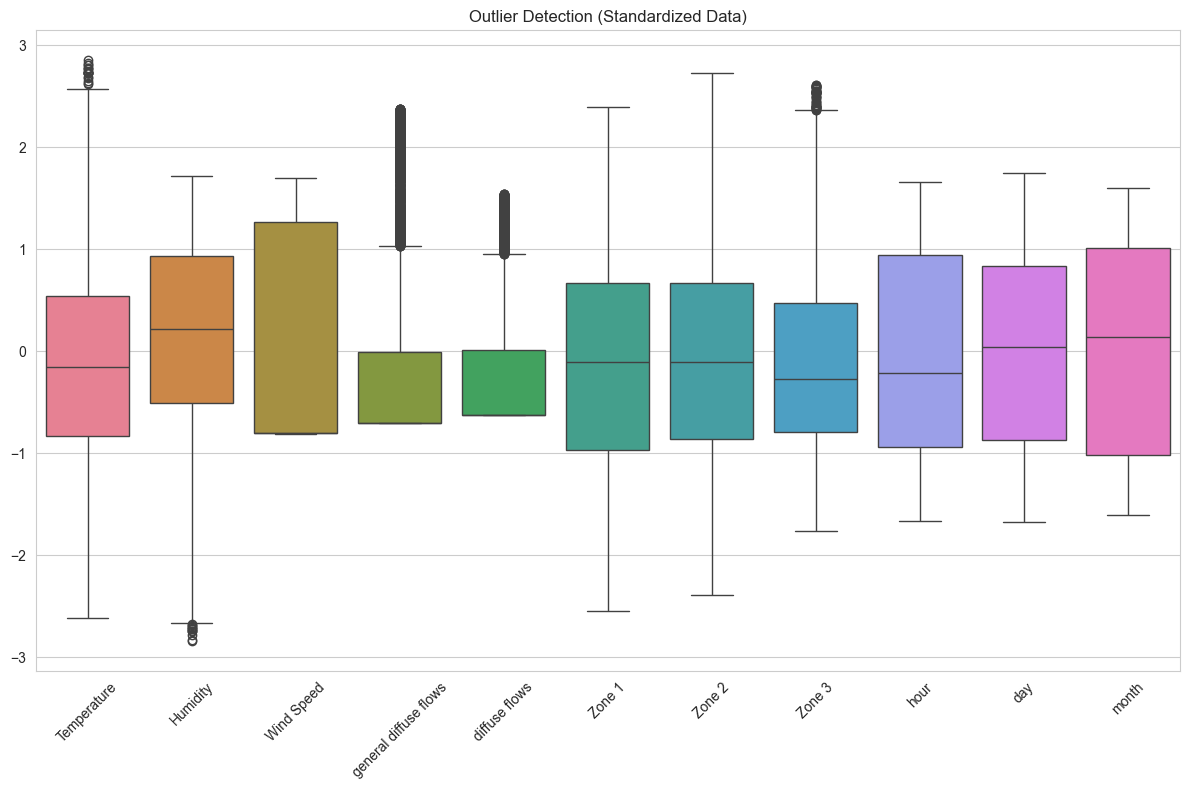

In [574]:
plot_multiple_boxplots(power_consumption_cleaned)

## Correlation HeatMap

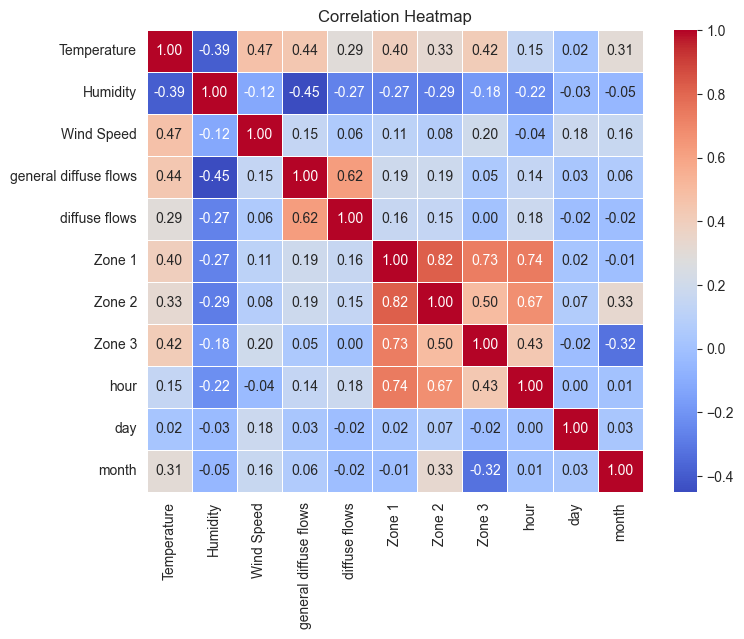

In [575]:
# Plot a heatmap of the correlations between numeric features
corr_matrix = power_consumption_cleaned.select_dtypes(include=['float64', 'int64', 'int32']).corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

**Conclusion:** After plotting correlation map, we can conclude that consumption of zones is most likely affected by hours of the day and slightly by the temperature 

## Model Training

In [576]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

linear_regression = LinearRegression()
random_forest = RandomForestRegressor(random_state=42,oob_score=True)

In [577]:
X = power_consumption_cleaned.drop(columns=['Zone 1','Zone 2','Zone 3'])
y = power_consumption_cleaned['Zone 1']

In [578]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=42)

In [579]:
random_forest.fit(X_train, y_train)
linear_regression.fit(X_train, y_train)

LinearRegression()

In [580]:
print(f'R Square for Random Forest Resgressor is: {random_forest.score(X_test, y_test)}')
print(f'R Square for Linear Regression is: {linear_regression.score(X_test, y_test)}')

R Square for Random Forest Resgressor is: 0.9523145208552842
R Square for Linear Regression is: 0.6728641177106651


**Conclusion**: After training the linear and random forest regressor model we could say that random forest perform better and will be adopted for regression. 

### OOB Score

In [581]:
# Access the OOB Score
oob_score = random_forest.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

Out-of-Bag Score: 0.9525374620148004


**Conclusion:** The OOB score represents the accuracy of the model. The value of 0.9525374620148004 in this case indicates that the model correctly predicts the target variable 95.25% of the time using the out-of-bag samples. It is a measure of how well the random forest classifier is generalizing to new, unseen data.

For more details, refer to this [article on Random Forests](https://medium.com/@ompramod9921/random-forests-32be04c8bf76).

## Feature Importance

In [582]:
# Get feature importance's
feature_importances = random_forest.feature_importances_

# Map feature importance's to feature names
feature_names = X.columns.tolist()  # Replace with your feature names if X is a NumPy array
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [583]:
importance_df

,Feature,Importance
5,hour,0.768765
0,Temperature,0.092133
7,month,0.064354
3,general diffuse flows,0.021946
6,day,0.017611
2,Wind Speed,0.013211
4,diffuse flows,0.011374
1,Humidity,0.010606


**Conclusion:** The electrical consumption is highly affected by hours of the day 